In [1]:
from datetime import date as D
from datetime import datetime as DT
from datetime import timedelta
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import socketserver
import sqlite3
import sys
import threading
import time
import urllib.request
import requests

In [2]:
### CONFIG ###
PORT = 8000
SENSOR_UPDATE_INTERVAL = 60  # seconds
GRAPH_UPDATE_INTERVAL = 900  # 900s = 15m
sensor1ip = 'http://192.168.4.1:42000'
jsonfile = r"/var/www/html/projects/greenbox/greenbox.js"
graphfile = r"/var/www/html/projects/greenbox/graph.png"
palette = ['xkcd:sea blue', 'xkcd:leaf green', '#efa00b',
           '#d65108', '#591f0a', '#F7F7F2']


### some stuff ###
# plt.ioff()


In [ ]:
def timestamp(deltaHours=False): 
    if not deltaHours:
        return time.strftime("%Y-%m-%d %H:%M:%S") 
    else:
        newtime = DT.now() + timedelta(hours=i)
        return (newtime).strftime("%Y-%m-%d %H:%M:%S")

In [8]:
def writeJS(res, jsonfile):
    filetext = "var imgtag = \"<img src='graph.png?"
    filetext += str(int(time.time()))
    filetext += "' alt='Sensor Data (24h)'></img>\"\n"
    filetext += "document.getElementById('graphImg').innerHTML = imgtag\n"
    
    jsonStream = {x[0] : list(x[1:]) for x in res}
    filetext += json2js(jsonStream)
    
    with open (jsonfile, "w") as f:
        f.write(filetext)

In [4]:
def json2js(sensor1):
    jsonString = "\njsonData = JSON.stringify(["
    jsonString += str(sensor1)
    jsonString += "]);\n"

    return jsonString

In [6]:
def dbinsert(jdata, c):
    if not (np.isnan(jdata["celsius"]) 
            or np.isnan(jdata["humidity"]) 
            or jdata["reservoir"] > 40 
            or jdata["ec"] <= 0 ):
        c.execute("INSERT INTO sensor1 VALUES " + 
                  ("('%s', %s, %s, %s, %s, %s, %s)" 
                  % (jdata['time'], jdata["celsius"], jdata["humidity"], 
                     jdata["heat index"], jdata["ph"], jdata["ec"], 
                     jdata["reservoir"])))
        return True

    else:
        print("%s\tReceived garbage data from sensor" % timestamp())
        return False



In [3]:
### Webserv ###
class Slave(threading.Thread):
    def run(self):
        self.kill = False
        self.ready = False
        import http.server
        Handler = http.server.SimpleHTTPRequestHandler
        try:
            httpd = socketserver.TCPServer(('0.0.0.0', PORT), Handler)
        except OSError as e:
            print (e)
            print("%s\tCaught socket exception, retrying..." % timestamp())
            time.sleep(10)
            self.run()

        self.ready = True

        while not self.kill:  # work hard until seppuku 
            httpd.handle_request()

        return

In [5]:
def read_sensor():
    try:
        req = requests.get(sensor1ip)
    except Exception as e:
        print(e)
        print("%s\tAn unknown error occurred, retrying..." % timestamp())
        time.sleep(10)
        return False

    if req.status_code is 200:
        jdata = req.json()
        print("%s temp:%s   humidity:%s  heat index:%s"
              % (timestamp(), jdata["celsius"],
                 jdata["humidity"], jdata["heat index"]))
        return jdata
    else:
        print("%s\tUnknown status code %d, retrying..."
              % (timestamp(), req.status_code))
        time.sleep(10)
        return False

In [59]:
def graph(c, debug=False, daterange=False):
    """
    [(0, 'time', 'datetime', 0, None, 0),
     (1, 'temp', 'float', 0, None, 0),
     (2, 'humidity', 'float', 0, None, 0),
     (3, 'heatindex', 'float', 0, None, 0),
     (4, 'ph', 'float', 0, None, 0),
     (5, 'ec', 'float', 0, None, 0),
     (6, 'reservoir', 'float', 0, None, 0)]
    """

    font = FontProperties()
    font.set_family('monospace')
    

    if daterange is False:
        query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
                 + r"datetime('now', 'localtime', '-1 days') AND "
                 + r"datetime('now', 'localtime')")
    else:
        query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
                 + r"datetime('now', 'localtime', '" + str(daterange[0]) 
                 +" days') AND "
                 + r"datetime('now', 'localtime', '" + str(daterange[1])
                 + " days')")

    c.execute(query)
    res = np.array(c.fetchall())

    if len(res) < 10:
        print("%s\tNot enough recent data to make graph" % timestamp())
        return

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
    #fig.patch.set_facecolor(palette[5])
    plt.suptitle("Sensor Data (24h)", fontproperties=font)
    plt.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)
    dates = [DT.strptime(t, "%Y-%m-%d %H:%M:%S") for t in res[:,0]]
    hours = mdates.HourLocator(interval=2)
    mins = mdates.MinuteLocator(byminute=[0, 30])
    fmt = mdates.DateFormatter("%H:%M")
    
    axs[0].set_title("Temperature (*C)", fontproperties=font)
    axs[0].plot(dates, res[:, 1].astype(float), c=palette[3], label="Ambient")
    axs[0].plot(dates, res[:, 6].astype(float), c=palette[0], label="Reservoir")
    axs[0].legend()
    axs[1].set_title("Humidity (%)", fontproperties=font)
    axs[1].plot(dates, res[:, 2].astype(float), c=palette[0])
    axs[1].fill_between(dates, res[:, 2].astype(float), alpha=0.2, color=palette[0])
    axs[2].set_title("Power of Hydrogen (pH)", fontproperties=font)
    axs[2].plot(dates, res[:, 4].astype(float), c=palette[1])
    axs[2].fill_between(dates, res[:, 4].astype(float), alpha=0.2, color=palette[1])
    axs[2].set_ylim([4,8])
    axs[3].set_title("Conductivity (mS/cm)", fontproperties=font)
    axs[3].plot(dates, (res[:, 5].astype(float)), c=palette[2])
    axs[3].fill_between(dates, res[:, 5].astype(float), alpha=0.2, color=palette[2])
    
    for ax in axs:
        ax.grid()
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(fmt)
        ax.xaxis.set_minor_locator(mins)
        ax.set_facecolor(palette[5])

    today = D.strftime(D.today(), "%m-%d")
    if debug:
        plt.xlabel("Time (%s debug=True)" % timestamp(), fontproperties=font)
    else:
        plt.xlabel("Time (%s)" % today, fontproperties=font)
    fig.autofmt_xdate()
    
    if debug:
        plt.show()
    else:
        plt.savefig(graphfile, facecolor=palette[5], edgecolor="red")
        plt.close()
        writeJS(res, jsonfile)
    
    return

In [9]:
### main loop ###
def update(c, conn, webslave):
    sensor_sleeptime = 0
    graph_sleeptime = 0
    
    while(webslave.ready is False):
        print("%s\tWaiting for webslave..." % timestamp())
        time.sleep(10)

    while (True):
        jdata = read_sensor()
        if jdata is False: continue

        if not (np.isnan(jdata["celsius"]) or np.isnan(jdata["humidity"])):
            c.execute("INSERT INTO sensor1 VALUES ('%s', %s, %s)"
                      % (timestamp(), jdata["celsius"], jdata["humidity"]))
        else:
            print("%s\tReceived garbage data from sensor" % timestamp())

        if sensor_sleeptime == graph_sleeptime:
            conn.commit()
            graph(c)

        t = time.time()
        sensor_sleeptime = SENSOR_UPDATE_INTERVAL - ((t % SENSOR_UPDATE_INTERVAL))
        graph_sleeptime = GRAPH_UPDATE_INTERVAL - ((t % GRAPH_UPDATE_INTERVAL))
        time.sleep(sensor_sleeptime)

In [10]:
#webslave = Slave()  # server to handle requests
#webslave.start()  # new thread
conn = sqlite3.connect("./sensordata.db")
c = conn.cursor()  # init db connection, pointer c

# Run through the operations of update(c, conn, webslave)



In [11]:
#print(webslave.ready)

We can provide some fake data while the sensor is not transmitting

In [12]:
#jdata = read_sensor()
jdata = {'celsius': 22.50, 
         'humidity': 40.20, 
         'heat index': 40.00, 
         'ph': 5.80, 
         'ec': 1.50, 
         'reservoir': 21.375, 
         'ph raw voltage': 0.797754}

print(json2js(jdata))


jsonData = JSON.stringify([{'celsius': 22.5, 'humidity': 40.2, 'heat index': 40.0, 'ph': 5.8, 'ec': 1.5, 'reservoir': 21.375, 'ph raw voltage': 0.797754}]);



write out the json data to json.js in the server directory.
it could be cool to provide js data webhooks later on 

In [13]:
# generate enough data for a crappy graph
query = r"DELETE FROM sensor1 WHERE time BETWEEN datetime('now', '-2 days') AND datetime('now', 'localtime')"
c.execute(query)

for i in range(-24,0):
    jdata = {'celsius': 22.50, 
         'humidity': 40.20, 
         'heat index': 40.00, 
         'ph': 5.80, 
         'ec': 1.50, 
         'reservoir': 21.375, 
         'ph raw voltage': 0.797754}
    
    for key in jdata.keys():
        jdata[key] += np.sin(i-.5)
    
    jdata['time'] = timestamp(i) 
    #print(timestamp(i))
    dbinsert(jdata, c)
    
conn.commit()

In [14]:
%matplotlib inline  # fancy

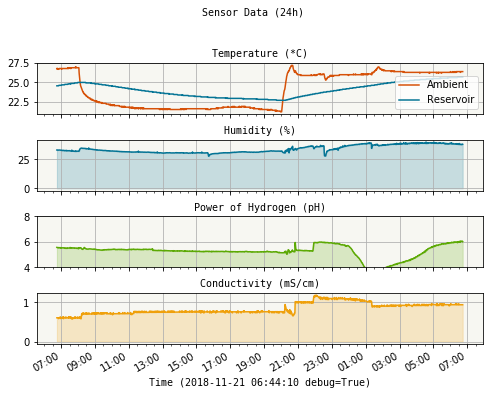

In [60]:
graph(c, debug=True, daterange=[-255, -254]) 

In [20]:
query = (r"SELECT * FROM sensor1 WHERE time BETWEEN "
             + r"datetime('now', 'localtime', '-365 days') AND "
             + r"datetime('now', 'localtime')")
c.execute(query)
res = np.array(c.fetchall())

In [77]:
#print(jsonStream)
jsonStream

{'2018-11-17 19:34:47': ['23.498082027979397',
  '41.198082027979396',
  '40.99808202797939',
  '6.798082027979396',
  '2.4980820279793963',
  '22.373082027979397'],
 '2018-11-17 20:34:47': ['22.98717451246051',
  '40.687174512460516',
  '40.48717451246051',
  '6.287174512460509',
  '1.9871745124605096',
  '21.86217451246051'],
 '2018-11-17 21:34:47': ['22.028360996905803',
  '39.728360996905806',
  '39.5283609969058',
  '5.328360996905804',
  '1.0283609969058038',
  '20.903360996905803'],
 '2018-11-17 22:34:47': ['21.5031702057212',
  '39.2031702057212',
  '39.0031702057212',
  '4.803170205721201',
  '0.5031702057212007',
  '20.3781702057212'],
 '2018-11-17 23:34:47': ['21.8944601302804',
  '39.5944601302804',
  '39.3944601302804',
  '5.194460130280399',
  '0.894460130280399',
  '20.7694601302804'],
 '2018-11-18 00:34:47': ['22.84248061846961',
  '40.54248061846962',
  '40.342480618469615',
  '6.142480618469612',
  '1.8424806184696125',
  '21.71748061846961'],
 '2018-11-18 01:34:47': 

In [ ]:
# nov 21: updates to update() and graph()

In [21]:
res[0]


array(['2018-03-09 01:10:00', '25.0', '24.3', '24.18981', '4.047626',
       '0.207039', '24.5625'], dtype='<U19')